In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
import matplotlib.pyplot as plt
import datetime

In [4]:
sd = datetime.datetime(2023,12,31)
ed = datetime.datetime(2024,12,31)

In [5]:
import yfinance as yf
googleinfo = yf.Ticker('GOOGL')
ggl = googleinfo.history(start = sd, end = ed)

In [6]:
ggl.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-01-02 00:00:00-05:00,138.049561,138.946304,135.987031,137.670929,23711200,0.0,0.0
2024-01-03 00:00:00-05:00,136.754247,139.125655,136.584863,138.418213,24212100,0.0,0.0
2024-01-04 00:00:00-05:00,137.920020,138.657353,135.857505,135.897354,27137700,0.0,0.0
2024-01-05 00:00:00-05:00,136.256066,136.664589,134.661839,135.239746,22506000,0.0,0.0
2024-01-08 00:00:00-05:00,135.797709,138.507885,135.767818,138.338501,21404000,0.0,0.0


In [7]:
ggl.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-12-23 00:00:00-05:00,192.619995,195.100006,190.149994,194.630005,25675000,0.0,0.0
2024-12-24 00:00:00-05:00,194.839996,196.110001,193.779999,196.110001,10403300,0.0,0.0
2024-12-26 00:00:00-05:00,195.149994,196.750000,194.380005,195.600006,12046600,0.0,0.0
2024-12-27 00:00:00-05:00,194.949997,195.320007,190.649994,192.759995,18891400,0.0,0.0
2024-12-30 00:00:00-05:00,189.800003,192.550003,189.119995,191.240005,14264700,0.0,0.0


<Axes: xlabel='Date'>

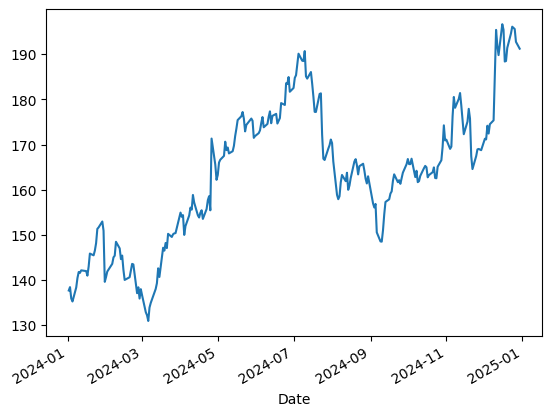

In [8]:
ggl['Close'].plot()

In [9]:
# check stationarity

from statsmodels.tsa.stattools import adfuller

In [10]:
test_result = adfuller(ggl['Close'])

In [11]:
def adfuller_test(close):
    result=adfuller(close)
    labels = ['ADF Test Statistic','p-value']
    for value,label in zip(result,labels):
        print(label+' : '+str(value))
    

In [12]:
adfuller_test(ggl['Close'])

ADF Test Statistic : -1.364654458368226
p-value : 0.5990990816514397


In [13]:
# Differencing

ggl['Close first difference'] = ggl['Close'].diff()

In [14]:
ggl[['Close', 'Close first difference']]

,Close,Close first difference
Date,,
2024-01-02 00:00:00-05:00,137.670929,NaN
2024-01-03 00:00:00-05:00,138.418213,0.747284
2024-01-04 00:00:00-05:00,135.897354,-2.520859
2024-01-05 00:00:00-05:00,135.239746,-0.657608
2024-01-08 00:00:00-05:00,138.338501,3.098755
...,...,...
2024-12-23 00:00:00-05:00,194.630005,3.220001
2024-12-24 00:00:00-05:00,196.110001,1.479996
2024-12-26 00:00:00-05:00,195.600006,-0.509995


In [15]:
adfuller_test(ggl['Close first difference'].dropna())

ADF Test Statistic : -12.329139545241045
p-value : 6.486406502149749e-23


<Axes: xlabel='Date'>

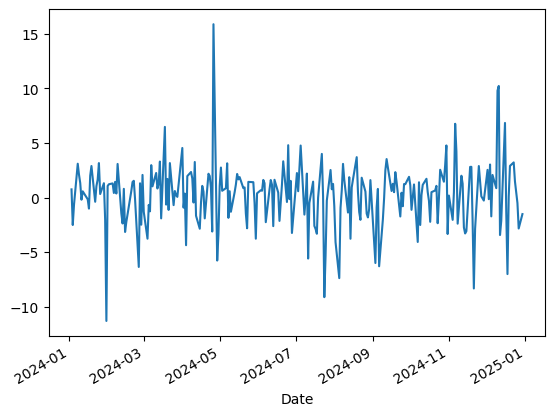

In [16]:
ggl['Close first difference'].plot()

In [17]:
# plot acf and pacf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

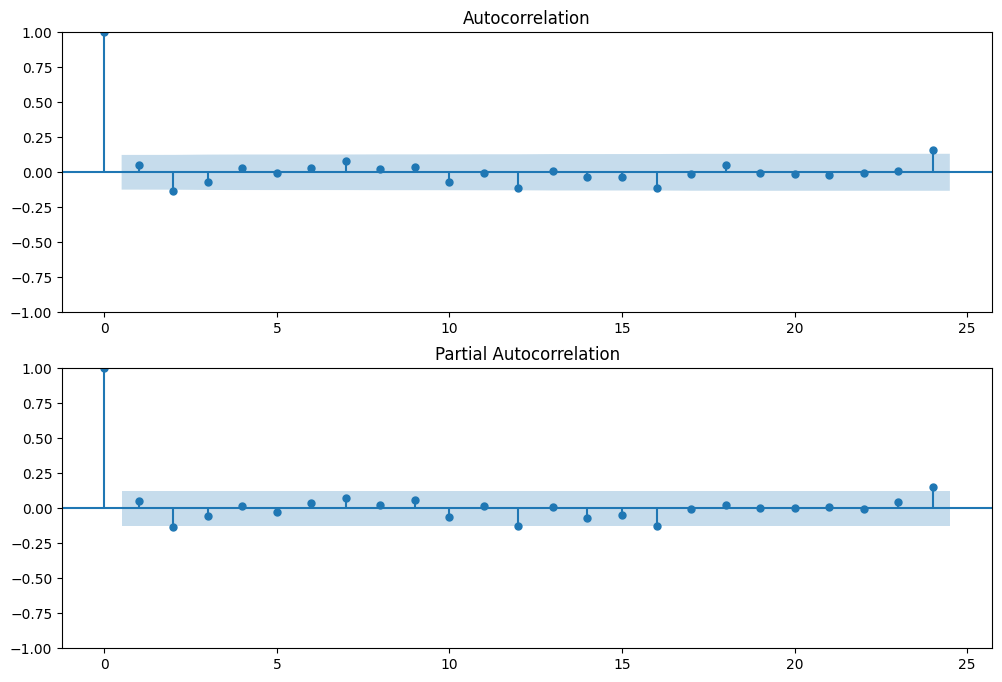

In [18]:
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(211)
fig1 = plot_acf(ggl['Close first difference'].iloc[1:], ax = ax1)
ax2 = fig.add_subplot(212)
fig2 = plot_pacf(ggl['Close first difference'].iloc[1:], ax = ax2)

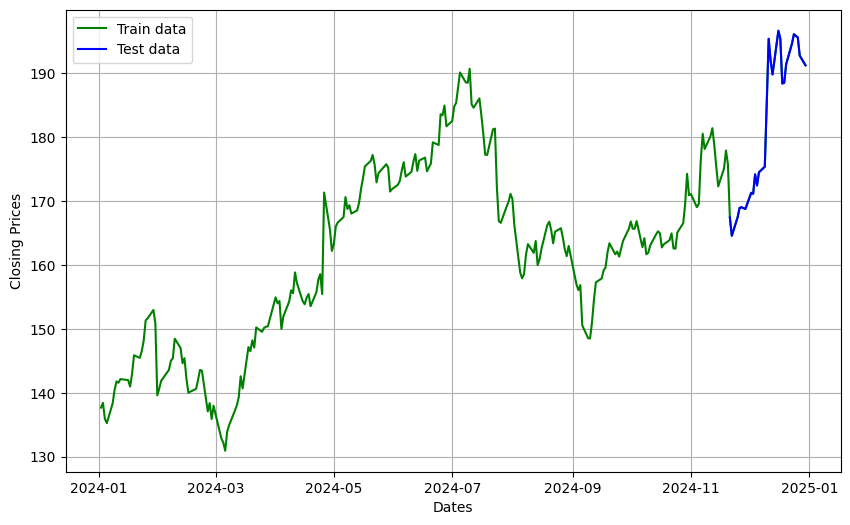

In [19]:
train_data, test_data = ggl[3:int(len(ggl)*0.9)], ggl[int(len(ggl)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(ggl['Close'], 'green', label='Train data')
plt.plot(test_data['Close'], 'blue', label='Test data')
plt.legend()

In [20]:
# ARIMA model

from statsmodels.tsa.arima.model import ARIMA

In [21]:
model = ARIMA(train_data['Close'],order = (1,1,1))
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -535.776
Date:                Tue, 28 Jan 2025   AIC                           1077.552
Time:                        06:28:04   BIC                           1087.746
Sample:                             0   HQIC                          1081.668
                                - 222                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9799      0.135      7.281      0.000       0.716       1.244
ma.L1         -0.9839      0.121     -8.107      0.000      -1.222      -0.746
sigma2         7.4686      0.361     20.661      0.000       6.760       8.177
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               327.26
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.06
Prob(H) (two-sided):                  0.62   Kurtosis:                         8.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


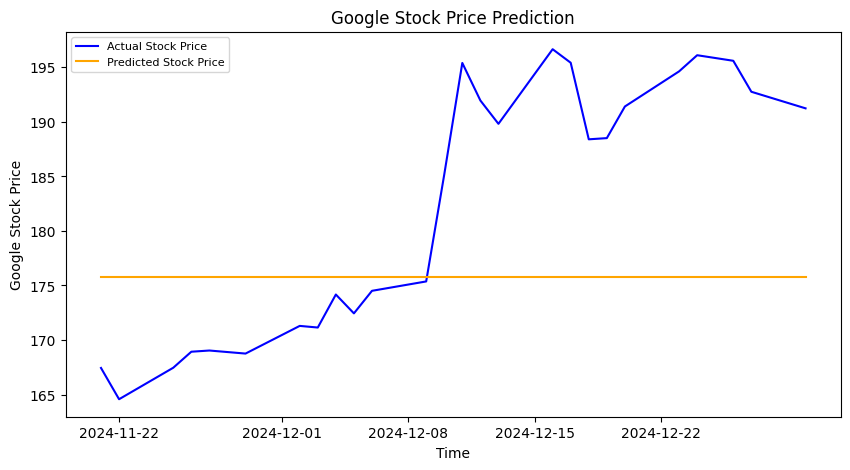

In [22]:
# Forecast
fc, se, conf = model_fit.forecast(3, alpha=0.05)  # 95% conf

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)

plt.plot(test_data['Close'], color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')

plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [23]:
# SARIMA model

import statsmodels.api as sm

In [24]:
model=sm.tsa.statespace.SARIMAX(ggl['Close'],order=(1, 1, 1),seasonal_order=(1,1,1,52))
results=model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [25]:
start = len(train_data)
 
# and it will end at the end of the test
end = len(train_data) + len(test_data) - 1
  
# apply the method predict
predictions = results.predict(start, end)
predictions

Date
2024-11-18 00:00:00-05:00    173.938142
2024-11-19 00:00:00-05:00    172.896678
2024-11-20 00:00:00-05:00    179.166308
2024-11-21 00:00:00-05:00    175.904159
2024-11-22 00:00:00-05:00    168.450006
2024-11-25 00:00:00-05:00    164.243149
2024-11-26 00:00:00-05:00    168.234530
2024-11-27 00:00:00-05:00    170.150747
2024-11-29 00:00:00-05:00    169.894304
2024-12-02 00:00:00-05:00    170.384744
2024-12-03 00:00:00-05:00    172.171643
2024-12-04 00:00:00-05:00    172.044009
2024-12-05 00:00:00-05:00    174.552761
2024-12-06 00:00:00-05:00    170.202176
2024-12-09 00:00:00-05:00    176.701639
2024-12-10 00:00:00-05:00    175.089099
2024-12-11 00:00:00-05:00    185.077374
2024-12-12 00:00:00-05:00    195.460663
2024-12-13 00:00:00-05:00    191.149033
2024-12-16 00:00:00-05:00    189.548614
2024-12-17 00:00:00-05:00    198.735515
2024-12-18 00:00:00-05:00    196.162215
2024-12-19 00:00:00-05:00    182.849242
2024-12-20 00:00:00-05:00    187.348296
2024-12-23 00:00:00-05:00    190.19

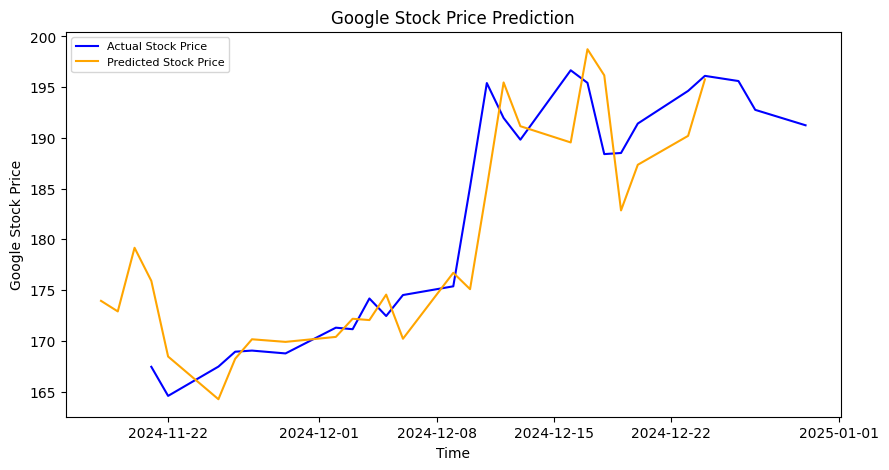

In [26]:
plt.figure(figsize=(10,5), dpi=100)

plt.plot(test_data['Close'], color = 'blue', label='Actual Stock Price')
plt.plot(predictions, color = 'orange',label='Predicted Stock Price')

plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()